# Behaviour Cloning Journey — Passive Walker  

This notebook walks through how we replace hand-crafted FSM controllers with small neural MLPs, variant by variant. You can toggle GPU acceleration via `USE_GPU_NOTEBOOK=True` at the top of each cell.

| Section | Variant            | Labels                         | MLP output dim | Key change                                 |
|---------|--------------------|--------------------------------|----------------|--------------------------------------------|
| 1       | Hip-only (MSE)     | FSM hip                        | 1              | Baseline 1-D MLP for hip                   |
| 2       | Knee-only (MSE)    | FSM left & right knees         | 2              | Two separate 1-D MLPs (one per knee)       |
| 3       | Hip + Knee (MSE)   | hip, left_knee, right_knee     | 3              | Single 3-D MLP controlling all three joints|
| 4       | Alt. losses        | MSE, Huber, L1 on 3-D output   | 3              | Compare different loss functions           |
| 5       | Combined loss      | MSE + symmetry + smoothness + energy + weight decay | 3 | Composite loss regularisation |
| 6       | Comparison & GUI   | All variants                   | —              | Side-by-side loss plots and short rollouts |

Each variant follows these four mini-steps:

1. **Collect FSM demo data**  
2. **Train** a small MLP via behavior cloning  
3. **Visualise** label distribution, loss curve, prediction vs. truth  
4. **Run** a short GUI roll-out to inspect gait  

Let’s get started with Section 1: Hip-only MSE.  

## 1 Setup & Imports

In [19]:
import numpy as np
import jax.numpy as jnp
import optax

from passive_walker.bc.utils import plot_label_hist, plot_loss_curve, plot_pred_vs_true


from passive_walker.constants import XML_PATH

print("Repo ready — model XML →", XML_PATH)

Repo ready — model XML → /home/yunusdanabas/passive_walker_rl/passiveWalker_model.xml


### Choose CPU / GPU for this notebook

In [20]:
USE_GPU_NOTEBOOK = True       

import os, jax
os.environ["JAX_PLATFORM_NAME"] = "gpu" if USE_GPU_NOTEBOOK else "cpu"
print("Running on:", jax.default_backend())

Running on: gpu


## 2 Hip‐only MSE   
### 2.1 Collect a mini demo set  
The demo collection uses FSM‐only hip control in MuJoCo.  

Collected obs (20000, 11), labels (20000, 1)


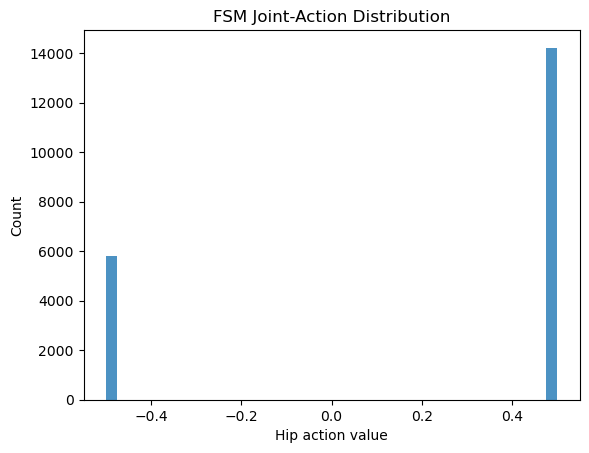

In [21]:
from passive_walker.bc.hip_mse.collect import collect_demo_data
from passive_walker.envs.mujoco_fsm_env   import PassiveWalkerEnv
from passive_walker.controllers.nn.hip_nn import HipController

DEMO_STEPS = 20_000

env_demo = PassiveWalkerEnv(
    xml_path=str(XML_PATH),
    simend=30,
    use_nn_for_hip=False,
    use_gui=False
)

obs, labels = collect_demo_data(env_demo, num_steps=DEMO_STEPS)
env_demo.close()

print(f"Collected obs {obs.shape}, labels {labels.shape}")
plot_label_hist(np.array(labels))

### 2.2 Train a MLP 
(For a full run, use the CLI script in `bc/hip_mse/run_pipeline.py`.)

[train] epoch 00  loss=0.0400
[train] epoch 01  loss=0.0330
[train] epoch 02  loss=0.0323
[train] epoch 03  loss=0.0290
[train] epoch 04  loss=0.0272
[train] epoch 05  loss=0.0198
[train] epoch 06  loss=0.0187
[train] epoch 07  loss=0.0176
[train] epoch 08  loss=0.0159
[train] epoch 09  loss=0.0140
[train] epoch 10  loss=0.0130
[train] epoch 11  loss=0.0133
[train] epoch 12  loss=0.0099
[train] epoch 13  loss=0.0131
[train] epoch 14  loss=0.0106
[train] epoch 15  loss=0.0109
[train] epoch 16  loss=0.0068
[train] epoch 17  loss=0.0073
[train] epoch 18  loss=0.0061
[train] epoch 19  loss=0.0072
[train] epoch 20  loss=0.0060
[train] epoch 21  loss=0.0063
[train] epoch 22  loss=0.0055
[train] epoch 23  loss=0.0088
[train] epoch 24  loss=0.0062
[train] epoch 25  loss=0.0054
[train] epoch 26  loss=0.0069
[train] epoch 27  loss=0.0057
[train] epoch 28  loss=0.0061
[train] epoch 29  loss=0.0058


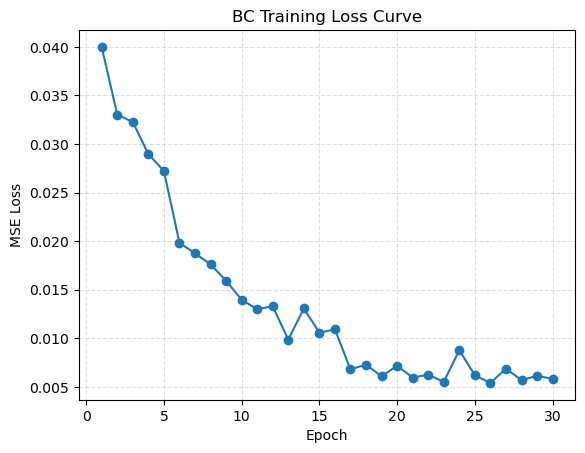

In [22]:
from passive_walker.bc.hip_mse.train import train_nn_controller

# Hyper-parameters
EPOCHS, BATCH, LR = 30, 32, 3e-4

# Initialize model & optimizer
hip_model     = HipController(input_size=obs.shape[1], hidden_size=128)
optimizer = optax.adam(LR)

hip_model, loss_hist = train_nn_controller(
    nn_controller=hip_model,
    optimizer=optimizer,
    demo_obs=obs,
    demo_labels=labels,
    num_epochs=EPOCHS,
    batch_size=BATCH,
    plot_loss=False,    # set True if you want to auto-save the plot to DATA_DIR
)

# Plot the training loss curve
plot_loss_curve(loss_hist)

### 2.3 Scatter: prediction vs ground-truth

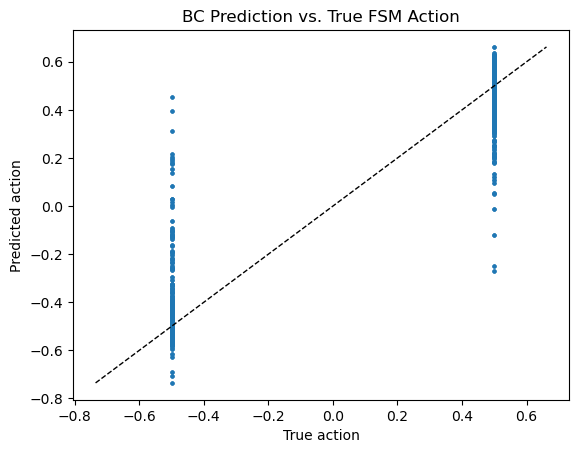

In [23]:
preds = np.array([hip_model(jnp.array(o)) for o in obs])
plot_pred_vs_true(np.array(labels), preds)

### 2.4 GUI roll-out (15 s)
Run only on a machine with a display.

In [24]:
from mujoco.glfw import glfw

env_test_hip = PassiveWalkerEnv(
    xml_path=str(XML_PATH),
    simend=15.0,
    use_nn_for_hip=True,
    use_gui=True
)
obs, done, total = env_test_hip.reset(), False, 0.0
while not done and not glfw.window_should_close(env_test_hip.window):
    act = np.array(hip_model(jnp.array(obs)))
    obs, rew, done, _ = env_test_hip.step(act)
    total += rew
    env_test_hip.render()
env_test_hip.close()
print("GUI rollout total reward:", total)

GUI rollout total reward: 4666.715710953667


## 3 Knee-only MSE  
We now repeat the pipeline, but recording **left & right knee actions**.

Device set to: gpu
Collected knee demos: obs (50000, 11), labels (50000, 2)


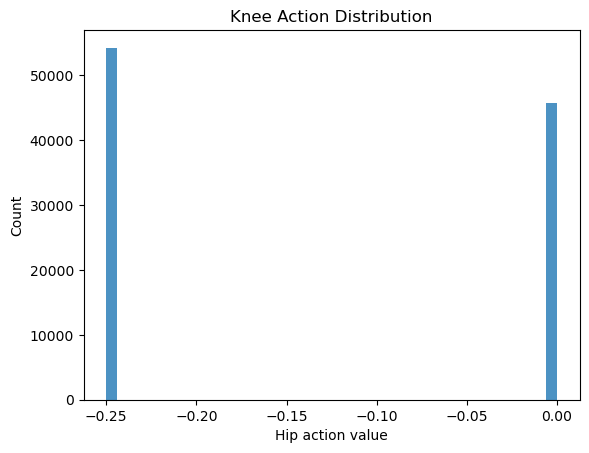

In [25]:
from passive_walker.bc.knee_mse        import set_device, XML_PATH as K_XML
from passive_walker.bc.knee_mse.collect import collect_demo_data
from passive_walker.envs.mujoco_fsm_env  import PassiveWalkerEnv

# 1) Configure CPU/GPU
set_device(USE_GPU_NOTEBOOK)

# 2) Collect demos
DEMO_STEPS_KNEE = 50_000
env_knee = PassiveWalkerEnv(
    xml_path=K_XML,
    simend=30,
    use_nn_for_hip=False,
    use_nn_for_knees=False,
    use_gui=False
)
obs_k, labels_k = collect_demo_data(env_knee, num_steps=DEMO_STEPS_KNEE)
env_knee.close()

# 3) Report & visualize
print(f"Collected knee demos: obs {obs_k.shape}, labels {labels_k.shape}")
plot_label_hist(np.array(labels_k), title="Knee Action Distribution")

### 3.2 Train a MLP (knee)

E0521 23:21:54.648336   69524 buffer_comparator.cc:156] Difference at 272: 0.00748628, expected -0.11619
E0521 23:21:54.648366   69524 buffer_comparator.cc:156] Difference at 274: 0.0561337, expected -0.0624086
E0521 23:21:54.648369   69524 buffer_comparator.cc:156] Difference at 282: 0.0387854, expected -0.0712399
E0521 23:21:54.648372   69524 buffer_comparator.cc:156] Difference at 290: 0.0464116, expected -0.0806845
E0521 23:21:54.648374   69524 buffer_comparator.cc:156] Difference at 293: 0.0582865, expected -0.0797219
E0521 23:21:54.648376   69524 buffer_comparator.cc:156] Difference at 298: 0.0146461, expected -0.0951902
E0521 23:21:54.648378   69524 buffer_comparator.cc:156] Difference at 313: 0.060052, expected -0.0922584
E0521 23:21:54.648381   69524 buffer_comparator.cc:156] Difference at 314: 0.0524285, expected -0.0539784
E0521 23:21:54.648383   69524 buffer_comparator.cc:156] Difference at 329: 0.00917791, expected -0.107247
E0521 23:21:54.648385   69524 buffer_comparator.

[train] epoch 00  loss=0.0019
[train] epoch 01  loss=0.0018
[train] epoch 02  loss=0.0013
[train] epoch 03  loss=0.0010
[train] epoch 04  loss=0.0010
[train] epoch 05  loss=0.0007
[train] epoch 06  loss=0.0008
[train] epoch 07  loss=0.0007
[train] epoch 08  loss=0.0006
[train] epoch 09  loss=0.0007
[train] epoch 10  loss=0.0008
[train] epoch 11  loss=0.0009
[train] epoch 12  loss=0.0008
[train] epoch 13  loss=0.0007
[train] epoch 14  loss=0.0006
[train] epoch 15  loss=0.0008
[train] epoch 16  loss=0.0009
[train] epoch 17  loss=0.0009
[train] epoch 18  loss=0.0008
[train] epoch 19  loss=0.0006
[train] epoch 20  loss=0.0007
[train] epoch 21  loss=0.0006
[train] epoch 22  loss=0.0004
[train] epoch 23  loss=0.0004
[train] epoch 24  loss=0.0014
[train] epoch 25  loss=0.0006
[train] epoch 26  loss=0.0005
[train] epoch 27  loss=0.0005
[train] epoch 28  loss=0.0004
[train] epoch 29  loss=0.0005
[train] epoch 30  loss=0.0004
[train] epoch 31  loss=0.0005
[train] epoch 32  loss=0.0004
[train] ep

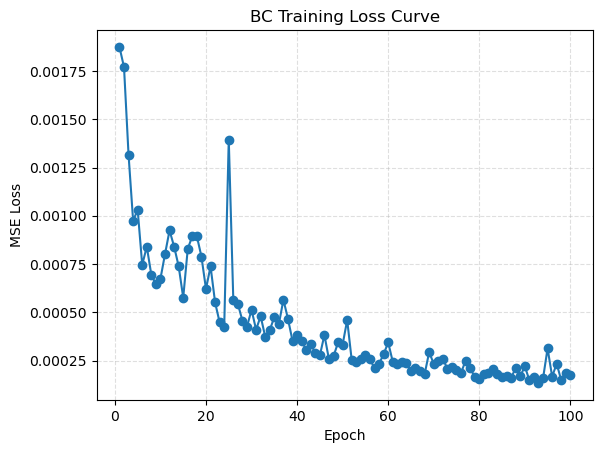

In [26]:
from passive_walker.controllers.nn.knee_nn import KneeController
from passive_walker.bc.knee_mse.train import train_nn_controller as train_knee_controller

# Hyper-parameters
EPOCHS_K, BATCH_K, LR_K = 100, 32, 1e-4

# Initialize model & optimizer
knee_model = KneeController(input_size=obs_k.shape[1], hidden_size=256)
knee_opt   = optax.adam(LR_K)

# Train (plot_loss=False means we’ll plot manually below)
knee_model, knee_loss_hist = train_knee_controller(
    nn_controller=knee_model,
    optimizer=knee_opt,
    demo_obs=obs_k,
    demo_labels=labels_k,
    num_epochs=EPOCHS_K,
    batch_size=BATCH_K,
    plot_loss=False,
)

# Plot the knee training loss curve
plot_loss_curve(knee_loss_hist)

### 3.3 Prediction vs Ground-Truth Scatter (Knee)

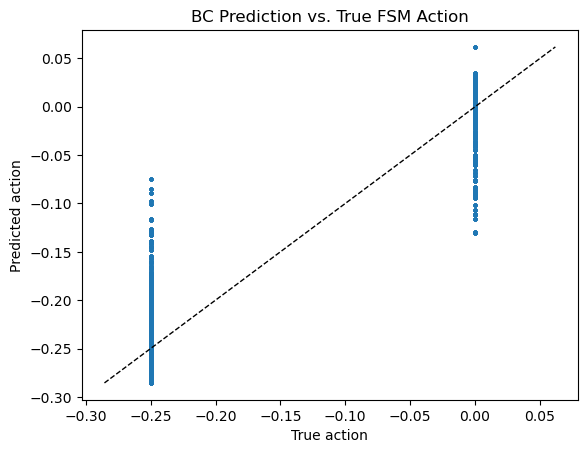

In [27]:
preds_k = np.array([knee_model(jnp.array(o)) for o in obs_k])
plot_pred_vs_true(np.array(labels_k), preds_k)

### 3.4 GUI roll-out (15 s)
Run only on a machine with a display.

In [28]:
from mujoco.glfw import glfw

env_test_knee = PassiveWalkerEnv(
    xml_path=str(XML_PATH),
    simend=15.0,
    use_nn_for_hip=False,
    use_nn_for_knees=True,
    use_gui=True
)
obs, done, total = env_test_knee.reset(), False, 0.0
while not done and not glfw.window_should_close(env_test_knee.window):
    act = np.array(knee_model(jnp.array(obs)))
    obs, rew, done, _ = env_test_knee.step(act)
    total += rew
    env_test_knee.render()
env_test_knee.close()
print("GUI rollout total reward:", total)

GUI rollout total reward: 2747.573633840655


## 4 Hip + Knee MSE  

We now train one MLP to predict **all three** actuator commands (hip, left knee, right knee).

### 4.1 Collect a mini demo set

Device set to: gpu
Collected hip+knee demos: obs (100000, 11), labels (100000, 3)


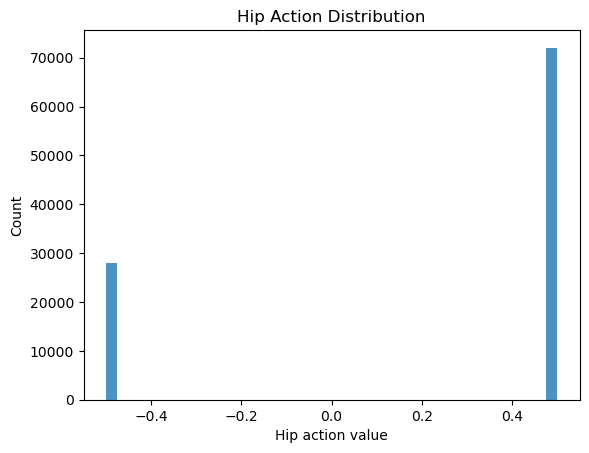

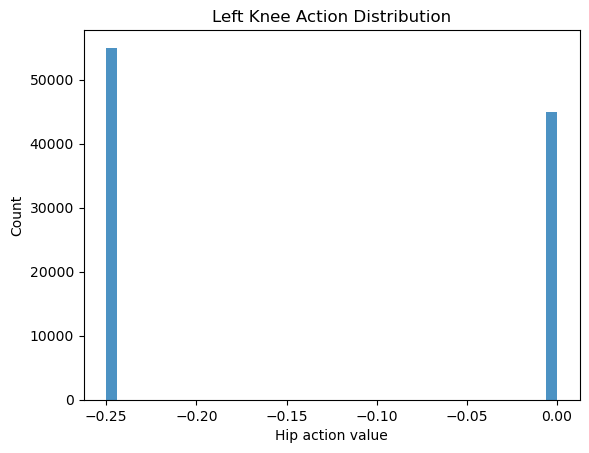

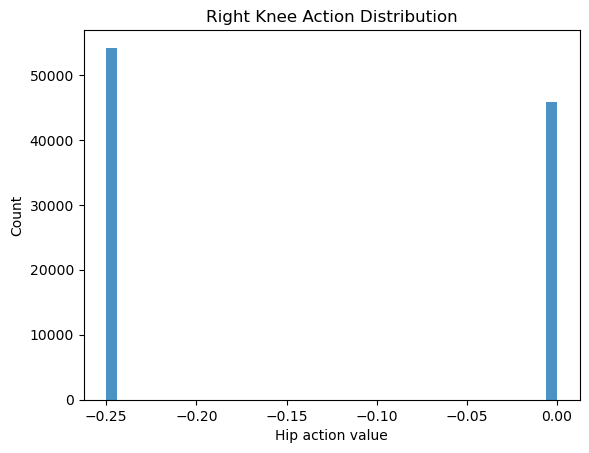

In [29]:
from passive_walker.bc.hip_knee_mse import set_device, XML_PATH 
from passive_walker.bc.hip_knee_mse.collect import collect_demo_data
from passive_walker.envs.mujoco_fsm_env import PassiveWalkerEnv

# 1) CPU/GPU toggle
set_device(USE_GPU_NOTEBOOK)

# 2) Collect demos
DEMO_STEPS_HK = 100_000

env_hk = PassiveWalkerEnv(
    xml_path=str(XML_PATH),
    simend=30,
    use_nn_for_hip=False,
    use_nn_for_knees=False,
    use_gui=False
)
obs_hk, labels_hk = collect_demo_data(env_hk, num_steps=DEMO_STEPS_HK)
env_hk.close()

# 3) Report & visualize
print(f"Collected hip+knee demos: obs {obs_hk.shape}, labels {labels_hk.shape}")
plot_label_hist(np.array(labels_hk[:,0]), title="Hip Action Distribution")
plot_label_hist(np.array(labels_hk[:,1]), title="Left Knee Action Distribution")
plot_label_hist(np.array(labels_hk[:,2]), title="Right Knee Action Distribution")

### 4.2 Train a MLP

[train] epoch 01  loss=0.0088
[train] epoch 02  loss=0.0082
[train] epoch 03  loss=0.0048
[train] epoch 04  loss=0.0039
[train] epoch 05  loss=0.0020
[train] epoch 06  loss=0.0023
[train] epoch 07  loss=0.0020
[train] epoch 08  loss=0.0030
[train] epoch 09  loss=0.0017
[train] epoch 10  loss=0.0015
[train] epoch 11  loss=0.0018
[train] epoch 12  loss=0.0012
[train] epoch 13  loss=0.0019
[train] epoch 14  loss=0.0013
[train] epoch 15  loss=0.0012
[train] epoch 16  loss=0.0013
[train] epoch 17  loss=0.0011
[train] epoch 18  loss=0.0011
[train] epoch 19  loss=0.0011
[train] epoch 20  loss=0.0009
[train] epoch 21  loss=0.0010
[train] epoch 22  loss=0.0009
[train] epoch 23  loss=0.0008
[train] epoch 24  loss=0.0007
[train] epoch 25  loss=0.0007
[train] epoch 26  loss=0.0007
[train] epoch 27  loss=0.0009
[train] epoch 28  loss=0.0017
[train] epoch 29  loss=0.0009
[train] epoch 30  loss=0.0005
[train] epoch 31  loss=0.0006
[train] epoch 32  loss=0.0009
[train] epoch 33  loss=0.0006
[train] ep

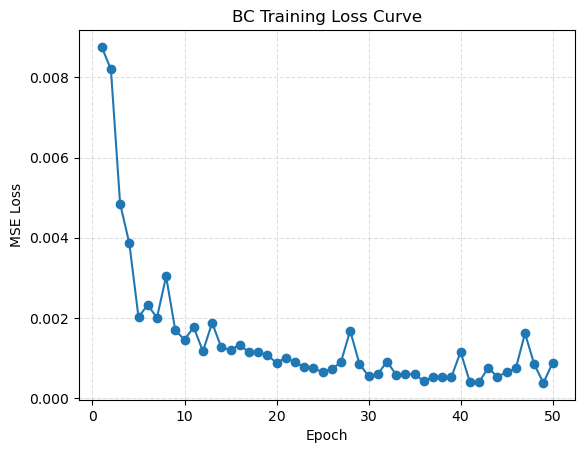

In [30]:
from passive_walker.controllers.nn.hip_knee_nn import HipKneeController
from passive_walker.bc.hip_knee_mse.train import train_nn_controller as train_hk

EPOCHS_HK, BATCH_HK, LR_HK = 50, 64, 3e-4

# Initialize model & optimizer
hk_model = HipKneeController(input_size=obs_hk.shape[1], hidden_size=256)
hk_opt   = optax.adam(LR_HK)

# Train & record loss
hk_model, hk_loss_hist = train_hk(
    model=hk_model,
    optimizer=hk_opt,
    obs=obs_hk,
    labels=labels_hk,
    epochs=EPOCHS_HK,
    batch=BATCH_HK,
    plot_loss=False,  
)

# Plot loss curve
plot_loss_curve(hk_loss_hist)

### 4.3 Prediction vs Ground-Truth  
Scatter for each action channel.

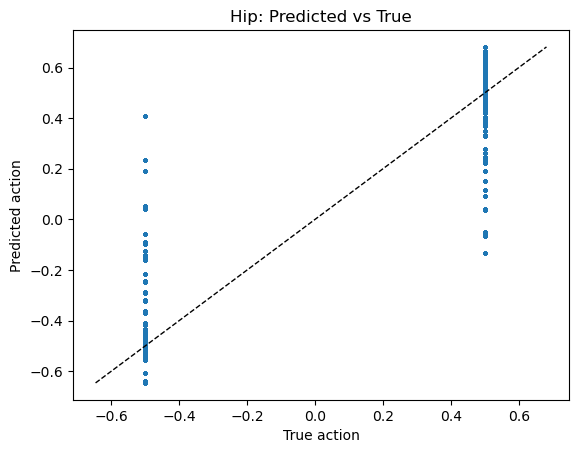

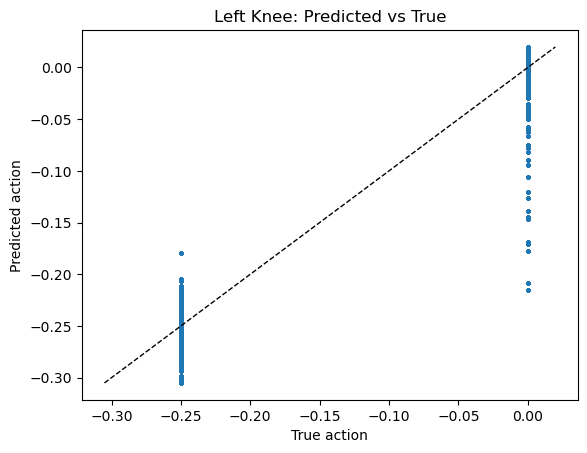

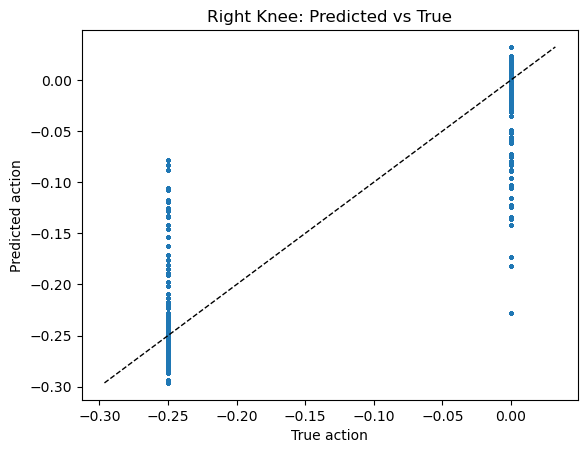

In [31]:
preds_hk = np.stack([np.array(hk_model(jnp.array(o))) for o in obs_hk], axis=0)

# Hip channel
plot_pred_vs_true(
    true=labels_hk[:,0],
    pred=preds_hk[:,0],
    title="Hip: Predicted vs True"
)

# Left knee channel
plot_pred_vs_true(
    true=labels_hk[:,1],
    pred=preds_hk[:,1],
    title="Left Knee: Predicted vs True"
)

# Right knee channel
plot_pred_vs_true(
    true=labels_hk[:,2],
    pred=preds_hk[:,2],
    title="Right Knee: Predicted vs True"
)

### 4.4 GUI Roll-Out (15 s)  
Verify both hip and knees are now controlled by the MLP.

In [32]:
from mujoco.glfw import glfw

env_test_hipKnee = PassiveWalkerEnv(
    xml_path=str(XML_PATH),
    simend=15.0,
    use_nn_for_hip=True,
    use_nn_for_knees=True,
    use_gui=True
)

obs, done, total = env_test_hipKnee.reset(), False, 0.0
while not done and not glfw.window_should_close(env_test_hipKnee.window):
    act = np.array(hk_model(jnp.array(obs)))   # 3-vector
    obs, r, done, _ = env_test_hipKnee.step(act)
    total += r
    env_test_hipKnee.render()
env_test_hipKnee.close()
print("Hip+Knee GUI reward:", total)

Hip+Knee GUI reward: 4450.889344271891


## 5 Alternative-Loss Comparison

In this section we will:

1. Collect a small hip+knee demo set  
2. Train four variants (MSE, Huber, L1, Combined) **in-notebook**  
3. Plot their loss curves side-by-side  
4. Run a short GUI rollout for each and compare total reward  
5. Play out the best one for a longer test  

In [40]:
# 5.1 Setup & Imports
import numpy as np
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from mujoco.glfw import glfw

from passive_walker.envs.mujoco_fsm_env import PassiveWalkerEnv
from passive_walker.controllers.nn.hip_knee_nn import HipKneeController
from passive_walker.bc.hip_knee_alternatives import set_device, XML_PATH
from passive_walker.bc.hip_knee_alternatives.collect import collect_demo_data

import passive_walker.bc.hip_knee_alternatives.train_mse     as mse_mod
import passive_walker.bc.hip_knee_alternatives.train_huber   as huber_mod
import passive_walker.bc.hip_knee_alternatives.train_l1      as l1_mod
import passive_walker.bc.hip_knee_alternatives.train_combined as comb_mod

# Toggle GPU if desired
USE_GPU_NOTEBOOK = True
set_device(USE_GPU_NOTEBOOK)

[bc] Using GPU


Hyperparameters

In [50]:
DEMO_STEPS   = 100_000
EPOCHS       = 50
BATCH_SIZE   = 64
HIDDEN_SIZE  = 256
LR           = 3e-4
SIM_DURATION = 10.0
SEED         = 42
HZ           = 1000

# Combined-loss weights
ALPHA_SYM    = 0.1
BETA_SMOOTH  = 0.1
GAMMA_ENERGY = 0.01

np.random.seed(SEED)

### 5.2 Collect a small demo set

In [51]:
env = PassiveWalkerEnv(
    xml_path=XML_PATH,
    simend=DEMO_STEPS/HZ,
    use_nn_for_hip=False,
    use_nn_for_knees=False,
    use_gui=False
)
obs, labels = collect_demo_data(env, num_steps=DEMO_STEPS)
env.close()

print(f"Collected: obs={obs.shape}, labels={labels.shape}")

Collected: obs=(100000, 11), labels=(100000, 3)


### 5.3 Train all four variants

In [52]:
variants = {
    "mse":      mse_mod.train_model,
    "huber":    huber_mod.train_model,
    "l1":       l1_mod.train_model,
    "combined": comb_mod.train_model,
}

results = {}
for name, train_fn in variants.items():
    print(f"\n--- Training {name.upper()} ---")
    key = jax.random.PRNGKey(SEED)
    model = HipKneeController(input_size=obs.shape[1], hidden_size=HIDDEN_SIZE, key=key)
    optimizer = optax.adam(LR)

    model, loss_hist = train_fn(
        obs=obs,
        labels=labels,
        loss_type=name,         
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        hidden_size=HIDDEN_SIZE,
        lr=LR,                
        verbose=True,
    )
    results[name] = (model, loss_hist)


--- Training MSE ---
[MSE] epoch 01  loss=0.0130
[MSE] epoch 02  loss=0.0117
[MSE] epoch 03  loss=0.0159
[MSE] epoch 04  loss=0.0056
[MSE] epoch 05  loss=0.0047
[MSE] epoch 06  loss=0.0054
[MSE] epoch 07  loss=0.0033
[MSE] epoch 08  loss=0.0044
[MSE] epoch 09  loss=0.0026
[MSE] epoch 10  loss=0.0034
[MSE] epoch 11  loss=0.0023
[MSE] epoch 12  loss=0.0021
[MSE] epoch 13  loss=0.0020
[MSE] epoch 14  loss=0.0029
[MSE] epoch 15  loss=0.0031
[MSE] epoch 16  loss=0.0049
[MSE] epoch 17  loss=0.0015
[MSE] epoch 18  loss=0.0032
[MSE] epoch 19  loss=0.0015
[MSE] epoch 20  loss=0.0021
[MSE] epoch 21  loss=0.0013
[MSE] epoch 22  loss=0.0016
[MSE] epoch 23  loss=0.0012
[MSE] epoch 24  loss=0.0018
[MSE] epoch 25  loss=0.0014
[MSE] epoch 26  loss=0.0011
[MSE] epoch 27  loss=0.0011
[MSE] epoch 28  loss=0.0011
[MSE] epoch 29  loss=0.0014
[MSE] epoch 30  loss=0.0010
[MSE] epoch 31  loss=0.0010
[MSE] epoch 32  loss=0.0012
[MSE] epoch 33  loss=0.0013
[MSE] epoch 34  loss=0.0009
[MSE] epoch 35  loss=0.000

### 5.4 Plot training loss curves

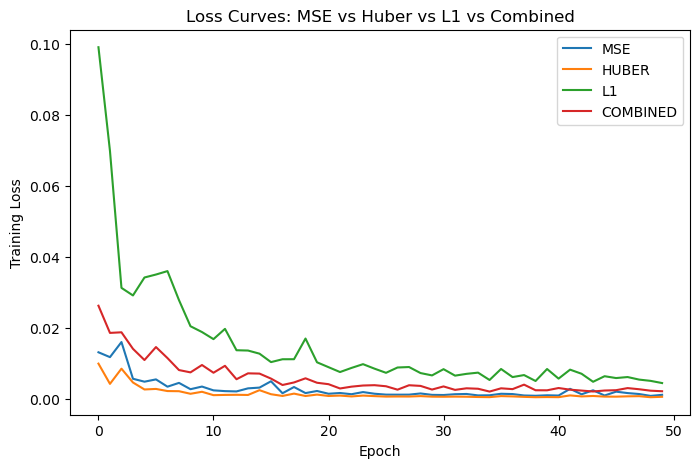

In [53]:
plt.figure(figsize=(8,5))
for name, (_, hist) in results.items():
    plt.plot(hist, label=name.upper())
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Loss Curves: MSE vs Huber vs L1 vs Combined")
plt.legend()
plt.show()

### 5.5 Short GUI rollouts & reward comparison

In [54]:
def gui_rollout(model, duration):
    env = PassiveWalkerEnv(
        xml_path=XML_PATH,
        simend=duration,
        use_nn_for_hip=True,
        use_nn_for_knees=True,
        use_gui=True
    )
    obs = env.reset()
    done = False
    total = 0.0
    while not done and not glfw.window_should_close(env.window):
        act = np.array(model(jnp.array(obs)))
        obs, r, done, _ = env.step(act)
        total += r
        env.render()
    env.close()
    return total

rewards = {}
for name, (model, _) in results.items():
    print(f"\n{name.upper()} rollout:")
    rewards[name] = gui_rollout(model, SIM_DURATION)
    print(f"  Reward = {rewards[name]:.3f}")

import pandas as pd
pd.DataFrame.from_dict(rewards, orient='index', columns=['Total Reward'])


MSE rollout:
  Reward = 2191.557

HUBER rollout:
  Reward = 63.579

L1 rollout:
  Reward = 2012.482

COMBINED rollout:
  Reward = 3133.690


,Total Reward
mse,2191.556541
huber,63.579167
l1,2012.482241
combined,3133.690033


### 5.6 Play best variant longer

In [55]:
best = max(rewards, key=rewards.get)
print(f"Best variant: {best.upper()} (reward {rewards[best]:.3f})")

print("Playing best for 2× duration…")
_ = gui_rollout(results[best][0], SIM_DURATION * 2)

Best variant: COMBINED (reward 3133.690)
Playing best for 2× duration…
